<a href="https://colab.research.google.com/github/jvieirax/BVSP/blob/main/BVSP_one_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [394]:
#Importando a Lib do Yahoo Finance
import yfinance as yf

In [395]:
# Symbol da Ibovespa e o intervalo de tempo
symbol = '^BVSP'
start_date = '2017-01-01'
end_date = '2023-12-12'

# Download do yf
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [396]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,60227.0,60227.0,59371.0,59589.0,59589.0,808700
2017-01-03,59631.0,61815.0,59631.0,61814.0,61814.0,3328300
2017-01-04,61811.0,61940.0,61302.0,61589.0,61589.0,2840800
2017-01-05,61594.0,62409.0,61594.0,62071.0,62071.0,3313000
2017-01-06,62072.0,62072.0,61396.0,61665.0,61665.0,2374800


In [397]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf


#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          #verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf         #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição sazonal usando médias móveis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

In [398]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1721 entries, 2017-01-02 to 2023-12-11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1721 non-null   float64
 1   High       1721 non-null   float64
 2   Low        1721 non-null   float64
 3   Close      1721 non-null   float64
 4   Adj Close  1721 non-null   float64
 5   Volume     1721 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 94.1 KB


In [399]:
df= df.reset_index('Date')


In [400]:
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime

In [401]:
df_bvsp = df_original # backup do dataset original
df_lstm = df_original # gravando variável para utilziar futuramente no outro modelo de lstm


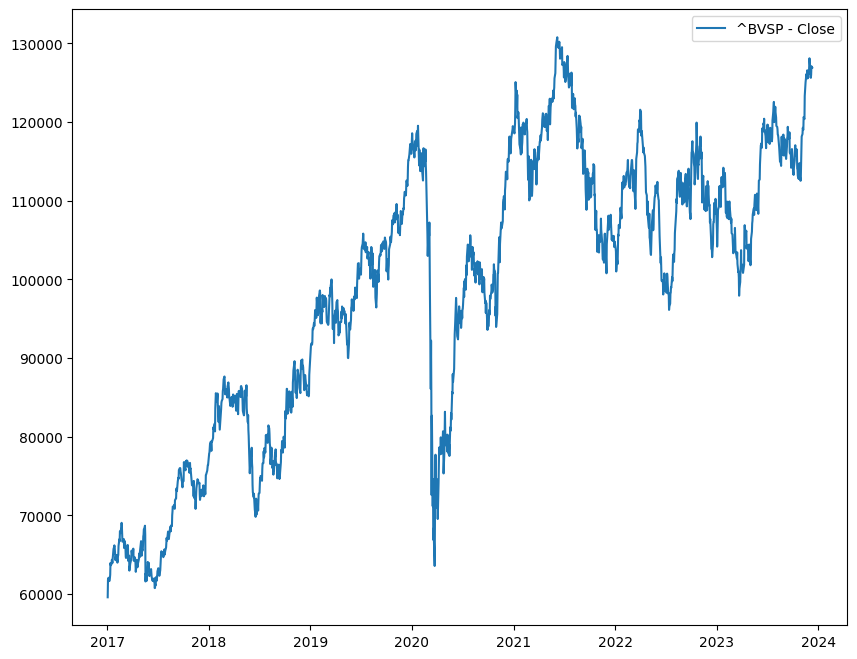

In [402]:
plt.figure(figsize = (10,8))
plt.plot(df['Date'], df['Close'], label='^BVSP - Close')

plt.legend(loc='best')
plt.show()

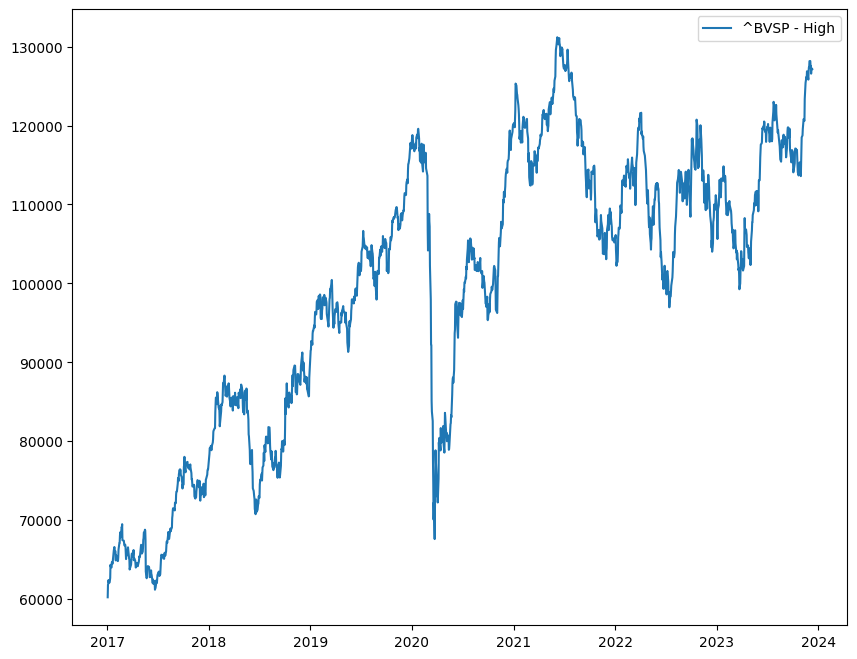

In [403]:
plt.figure(figsize = (10,8))
plt.plot(df['Date'], df['High'], label='^BVSP - High')

plt.legend(loc='best')
plt.show()

In [404]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,60227.0,60227.0,59371.0,59589.0,59589.0,808700
1,2017-01-03,59631.0,61815.0,59631.0,61814.0,61814.0,3328300
2,2017-01-04,61811.0,61940.0,61302.0,61589.0,61589.0,2840800
3,2017-01-05,61594.0,62409.0,61594.0,62071.0,62071.0,3313000
4,2017-01-06,62072.0,62072.0,61396.0,61665.0,61665.0,2374800


Prophet é uma biblioteca em Python para previsão de séries temporais. Ela foi desenvolvida pela equipe de Ciência de Dados do Facebook e oferece uma abordagem automatizada para prever dados de séries temporais com base em um modelo aditivo. Aqui estão algumas das principais funcionalidades do Prophet:

Modelagem Automatizada: O Prophet é projetado para fazer previsões automaticamente, sem a necessidade de ajustes manuais complexos. Ele detecta tendências não lineares e sazonalidades anuais, semanais e diárias nos dados de séries temporais.

Robustez: O Prophet lida bem com dados ausentes e mudanças nas tendências. Ele também é capaz de lidar com valores atípicos de forma eficaz.

Sazonalidade: O modelo do Prophet incorpora sazonalidades, como feriados, que podem afetar os dados de séries temporais.

Histórico de Dados: O Prophet funciona melhor quando há várias temporadas de dados históricos disponíveis.

In [405]:
df.drop(columns=['Open', 'Low', 'Volume', 'Adj Close','High'], inplace=True)


In [406]:
df[['ds','y']] = df[['Date','Close']]  # ds e y é o mínimo para uma previsão de serie temporal, coloquei mais uma feature que é o High
df.head()

,Date,Close,ds,y
0,2017-01-02,59589.0,2017-01-02,59589.0
1,2017-01-03,61814.0,2017-01-03,61814.0
2,2017-01-04,61589.0,2017-01-04,61589.0
3,2017-01-05,62071.0,2017-01-05,62071.0
4,2017-01-06,61665.0,2017-01-06,61665.0


In [407]:
#Treino e teste
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (1377, 4)
testing data size : (344, 4)


In [408]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=365, freq='D')  # diário com forecast de 365 dias
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3veljfgf/j3pg0drf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3veljfgf/t0_aqcs5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10251', 'data', 'file=/tmp/tmp3veljfgf/j3pg0drf.json', 'init=/tmp/tmp3veljfgf/t0_aqcs5.json', 'output', 'file=/tmp/tmp3veljfgf/prophet_modelmy08d9b7/prophet_model-20240113195855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:58:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:58:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-02,59328.101712,54966.286696,69628.169078,59328.101712,59328.101712,3360.822063,3360.822063,3360.822063,1154.762542,...,51.080370,51.080370,51.080370,2154.979151,2154.979151,2154.979151,0.0,0.0,0.0,62688.923775
1,2017-01-03,59371.555883,55878.827174,70634.188146,59371.555883,59371.555883,3854.976923,3854.976923,3854.976923,1154.762542,...,307.356786,307.356786,307.356786,2392.857595,2392.857595,2392.857595,0.0,0.0,0.0,63226.532806
2,2017-01-04,59415.010054,56374.881716,70003.619123,59415.010054,59415.010054,3690.848256,3690.848256,3690.848256,1154.762542,...,-97.133076,-97.133076,-97.133076,2633.218790,2633.218790,2633.218790,0.0,0.0,0.0,63105.858309
3,2017-01-05,59458.464225,56270.114090,70200.314122,59458.464225,59458.464225,4020.937309,4020.937309,4020.937309,1154.762542,...,-7.366476,-7.366476,-7.366476,2873.541243,2873.541243,2873.541243,0.0,0.0,0.0,63479.401534
4,2017-01-06,59501.918395,56112.378742,70361.015391,59501.918395,59501.918395,4300.875396,4300.875396,4300.875396,1154.762542,...,34.753662,34.753662,34.753662,3111.359192,3111.359192,3111.359192,0.0,0.0,0.0,63802.793792


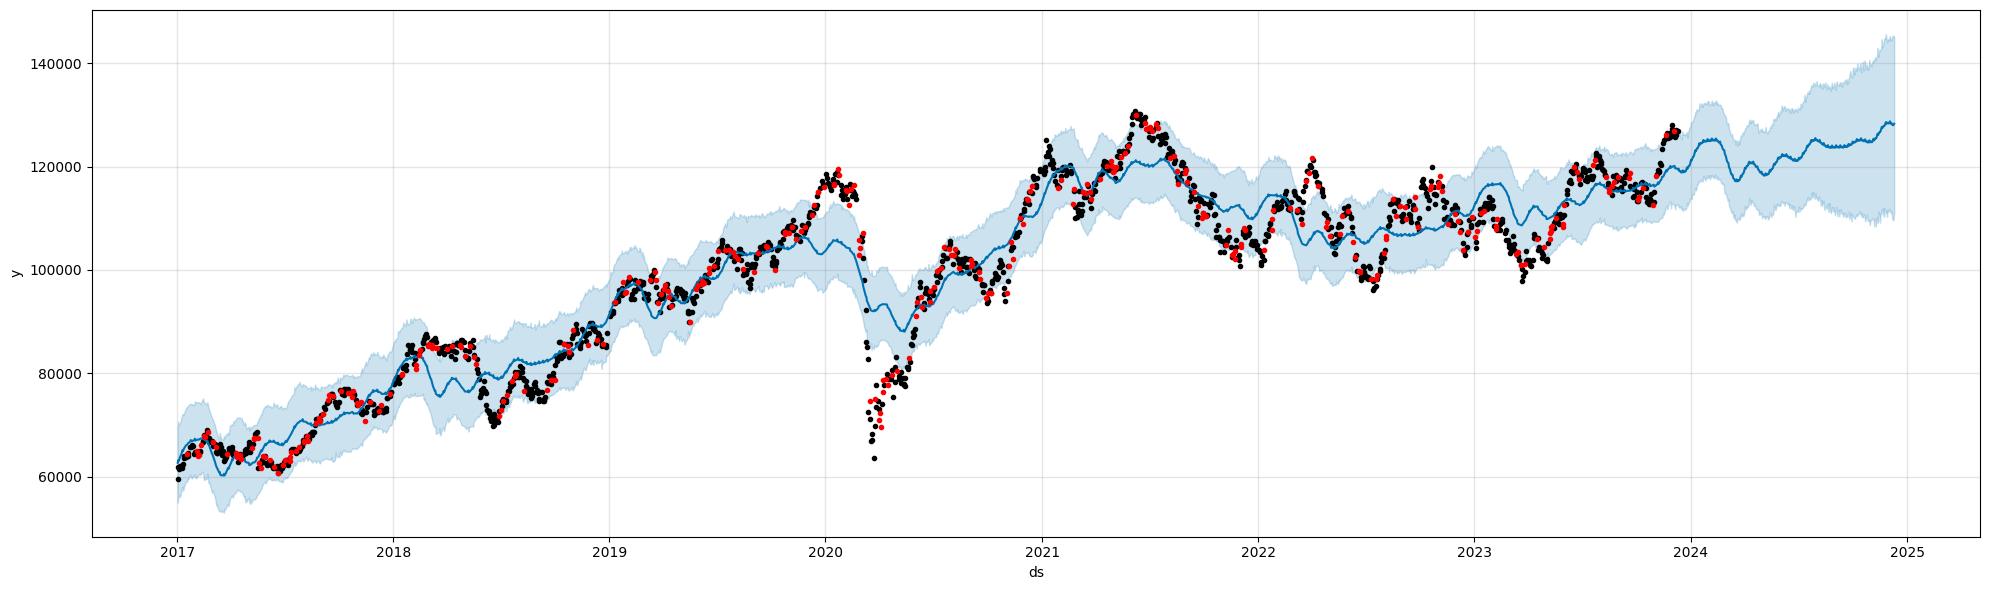

In [409]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

In [410]:
previsao.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1737,2024-12-06,125824.206625,110867.114207,144455.947138,109949.939902,140987.260752,2492.200510,2492.200510,2492.200510,1154.762542,...,34.753662,34.753662,34.753662,1302.684305,1302.684305,1302.684305,0.0,0.0,0.0,128316.407135
1738,2024-12-07,125847.671470,109807.470499,145157.588850,109924.770039,141121.637150,2215.686068,2215.686068,2215.686068,1154.762542,...,-144.345644,-144.345644,-144.345644,1205.269169,1205.269169,1205.269169,0.0,0.0,0.0,128063.357538
1739,2024-12-08,125871.136315,109581.797556,145365.726206,109856.655302,141249.188895,2112.063782,2112.063782,2112.063782,1154.762542,...,-144.345621,-144.345621,-144.345621,1101.646861,1101.646861,1101.646861,0.0,0.0,0.0,127983.200097
1740,2024-12-09,125894.601160,109892.418826,145199.658177,109851.407807,141333.613822,2200.071181,2200.071181,2200.071181,1154.762542,...,51.080370,51.080370,51.080370,994.228269,994.228269,994.228269,0.0,0.0,0.0,128094.672340
1741,2024-12-10,125918.066004,110933.284197,145138.539310,109854.552077,141412.255519,2347.643734,2347.643734,2347.643734,1154.762542,...,307.356786,307.356786,307.356786,885.524406,885.524406,885.524406,0.0,0.0,0.0,128265.709738


In [411]:
previsao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1742 entries, 0 to 1741
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          1742 non-null   datetime64[ns]
 1   trend                       1742 non-null   float64       
 2   yhat_lower                  1742 non-null   float64       
 3   yhat_upper                  1742 non-null   float64       
 4   trend_lower                 1742 non-null   float64       
 5   trend_upper                 1742 non-null   float64       
 6   additive_terms              1742 non-null   float64       
 7   additive_terms_lower        1742 non-null   float64       
 8   additive_terms_upper        1742 non-null   float64       
 9   daily                       1742 non-null   float64       
 10  daily_lower                 1742 non-null   float64       
 11  daily_upper                 1742 non-null   float64     

In [412]:
filtered_df = previsao[(previsao['ds'] >=  '2023-02-13') & (previsao['ds'] <= '2023-12-15')]
filtered_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1206,2023-02-13,110290.479338,109345.727221,124047.236004,110290.479338,110290.479338,6307.562389,6307.562389,6307.562389,1154.762542,...,51.080370,51.080370,51.080370,5101.719477,5101.719477,5101.719477,0.0,0.0,0.0,116598.041726
1207,2023-02-14,110313.944183,109340.886850,124026.655155,110313.944183,110313.944183,6503.735672,6503.735672,6503.735672,1154.762542,...,307.356786,307.356786,307.356786,5041.616344,5041.616344,5041.616344,0.0,0.0,0.0,116817.679854
1208,2023-02-15,110337.409027,108694.467830,123090.635045,110337.409027,110337.409027,6024.077929,6024.077929,6024.077929,1154.762542,...,-97.133076,-97.133076,-97.133076,4966.448463,4966.448463,4966.448463,0.0,0.0,0.0,116361.486957
1209,2023-02-16,110360.873872,109525.370052,123168.624005,110360.873872,110360.873872,6021.722891,6021.722891,6021.722891,1154.762542,...,-7.366476,-7.366476,-7.366476,4874.326825,4874.326825,4874.326825,0.0,0.0,0.0,116382.596763
1210,2023-02-17,110384.338717,109017.677612,123297.996139,110384.338717,110384.338717,5953.015714,5953.015714,5953.015714,1154.762542,...,34.753662,34.753662,34.753662,4763.499510,4763.499510,4763.499510,0.0,0.0,0.0,116337.354431


In [413]:
previsao.to_excel('previsao.xlsx', index=True)


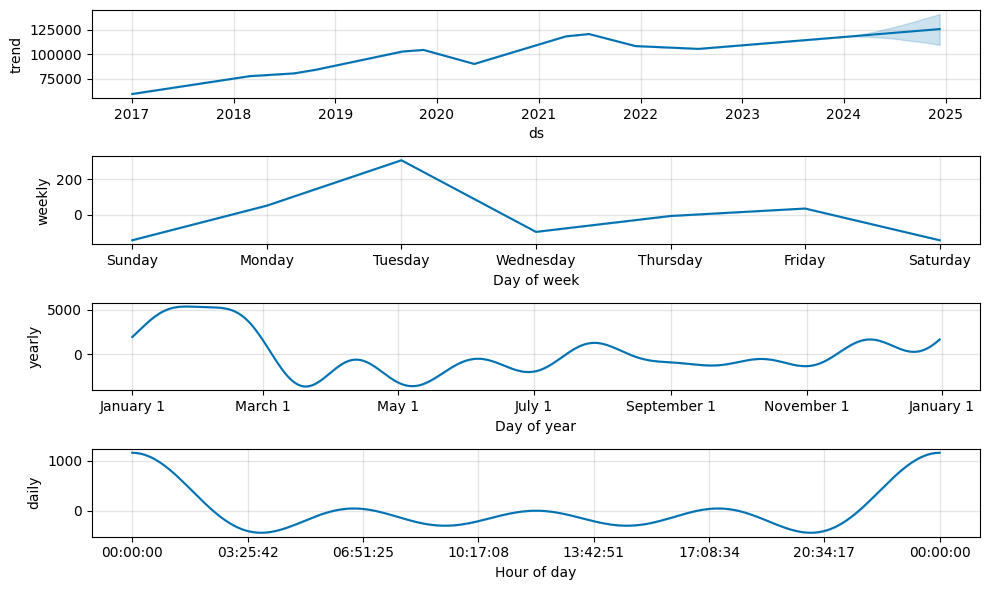

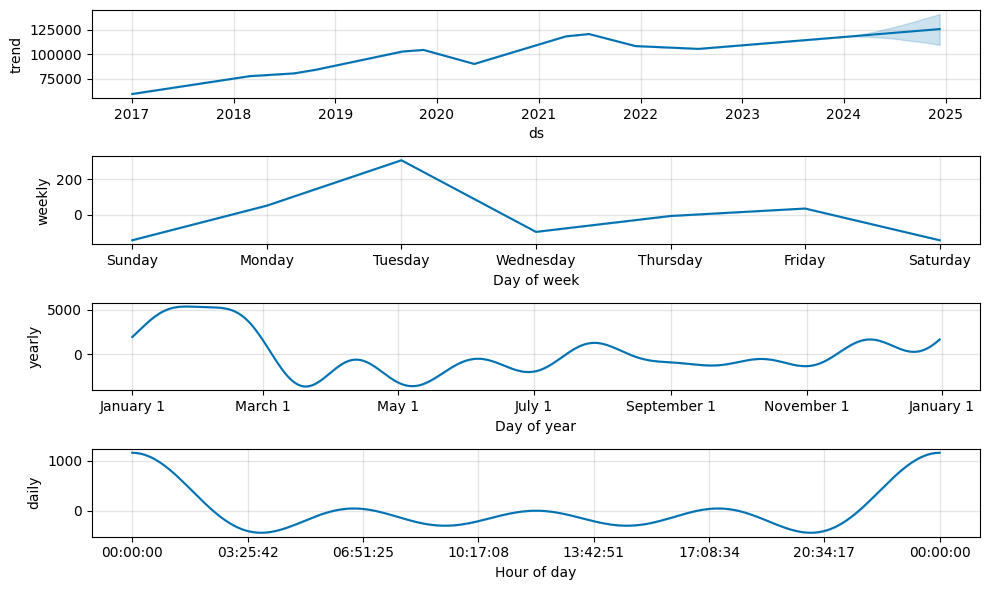

In [414]:
modelo.plot_components(previsao, figsize=(10,6))

In [415]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 4.57%


In [416]:
#  Cross Validation
from prophet.diagnostics import cross_validation

df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon = '365 days')

INFO:prophet:Making 8 forecasts with cutoffs between 2019-06-30 00:00:00 and 2022-12-11 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3veljfgf/5tq99b4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3veljfgf/gll9io24.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20824', 'data', 'file=/tmp/tmp3veljfgf/5tq99b4g.json', 'init=/tmp/tmp3veljfgf/gll9io24.json', 'output', 'file=/tmp/tmp3veljfgf/prophet_modeloz12uami/prophet_model-20240113195901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:59:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:59:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3veljfgf/rxlfbsa6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3veljfgf/a8a0jd_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [417]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-07-01,97804.194976,95674.464725,99963.594436,101340.0,2019-06-30
1,2019-07-02,98240.308669,95842.446637,100423.756565,100605.0,2019-06-30
2,2019-07-03,98189.029540,95919.081312,100378.967651,102043.0,2019-06-30
3,2019-07-05,98886.329980,96484.195959,101178.977758,104089.0,2019-06-30
4,2019-07-08,99807.110150,97589.392657,101914.048720,104530.0,2019-06-30


In [418]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,1.231145e+08,11095.695604,8663.238539,0.081127,0.053502,0.081813,0.424204
1,37 days,1.230175e+08,11091.323696,8661.612986,0.081064,0.053502,0.081746,0.421656
2,38 days,1.224961e+08,11067.797667,8649.095234,0.080972,0.053502,0.081597,0.414013
3,39 days,1.224125e+08,11064.016430,8635.665753,0.080771,0.052572,0.081402,0.414013
4,40 days,1.201783e+08,10962.585750,8496.520784,0.079340,0.050171,0.080011,0.411465
...,...,...,...,...,...,...,...,...
325,361 days,1.355083e+09,36811.456262,30115.363191,0.270689,0.190751,0.277707,0.379618
326,362 days,1.370138e+09,37015.378305,30229.030620,0.270094,0.190751,0.279583,0.378344
327,363 days,1.405316e+09,37487.541004,30663.106969,0.273264,0.190751,0.284555,0.375796
328,364 days,1.374875e+09,37079.308828,30265.058386,0.269197,0.188289,0.280816,0.384713


#Aplicando LSTM (Long short-term memory)

LSTM é uma sigla para **Memória de Longo Prazo e Curto Prazo**. É uma arquitetura de rede neural recorrente que é capaz de processar informações sequenciais ¹²³. A LSTM é capaz de capturar tanto o longo quanto o curto prazo, minimizando o efeito da utilização somente do curtíssimo prazo como acontece na arquitetura de uma RNN tradicional ¹. A LSTM é composta por unidades de memória que permitem que a rede aprenda a armazenar e acessar informações relevantes por longos períodos de tempo ⁴. A arquitetura de uma LSTM é mais robusta do que a de uma RNN convencional, pois há muito mais fluxo de informações circulando ¹.

Origem: conversa com o Bing, 13/01/2024
(1) O que é e como funciona uma LSTM passo-a-passo. https://didatica.tech/lstm-long-short-term-memory/.
(2) Long Short Term Memory: redes neurais artificiais que são capazes de .... https://ateliware.com/blog/long-short-term-memory/.
(3) LSTM em Deep Learning: Modelos de Memória de Longo Prazo. https://awari.com.br/lstm-em-deep-learning-modelos-de-memoria-de-longo-prazo/.
(4) O que é Long Short-Term Memory (LSTM)? - Guia de Hospedagem. https://guiadehospedagem.com.br/glossario/o-que-e-long-short-term-memory-lstm/.
(5) undefined. https://colah.github.io/posts/2015-08-Understanding-LSTMs/.

In [419]:
# Symbol da Ibovespa e o intervalo de tempo
symbol = '^BVSP'
start_date = '2017-01-01'
end_date = '2023-12-12'

# Download do yf
df_lstm = yf.download(symbol, start=start_date, end=end_date)

df_lstm = df_lstm.reset_index('Date')
df_lstm['Date'] = pd.to_datetime(df_lstm['Date']) #realizando a conversão da data para formato datetime
df_lstm.head()

[*********************100%%**********************]  1 of 1 completed


In [421]:
df_lstm.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)

df_lstm.head()

,Date,Close
0,2017-01-02,59589.0
1,2017-01-03,61814.0
2,2017-01-04,61589.0
3,2017-01-05,62071.0
4,2017-01-06,61665.0


In [422]:
close_data = df_lstm['Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

In [423]:
scaler = MinMaxScaler(feature_range=(0, 1))  #Normalizando os dados
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [424]:
split_percent = 0.80  #Separação da base de treino e teste:
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df_lstm['Date'][:split]
date_test = df_lstm['Date'][split:]

print(len(close_train))
print(len(close_test))

1376
345


In [425]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [426]:
from tensorflow.keras.metrics import MeanSquaredError

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
69/69 [==============================] - 2s 9ms/step - loss: 0.0487 - mean_squared_error: 0.0487
Epoch 2/20
69/69 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 3/20
69/69 [==============================] - 1s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 4/20
69/69 [==============================] - 1s 8ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 5/20
69/69 [==============================] - 1s 8ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 6/20
69/69 [==============================] - 1s 9ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 7/20
69/69 [==============================] - 1s 8ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 8/20
69/69 [==============================] - 1s 13ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 9/20
69/69 [==============================] - 1s 13ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 10/20
69/69 [=======

In [427]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

335/335 [==============================] - 2s 4ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Erro Quadrático Médio 0.002668116707354784


In [428]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')


335/335 [==============================] - 2s 6ms/step
MAPE: 2.7592


In [429]:
#O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.051653815999931546


O RMSE fornece uma métrica de erro na mesma unidade que a variável alvo (nesse caso, o preço de fechamento). Portanto significa que, em média, as previsões do modelo estão desviando em torno de 0.025 unidades da variável de destino. Quanto menor o RMSE, melhor é o desempenho do modelo em termos de previsões de regressão.

In [430]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da BOVESPA",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

335/335 [==============================] - 2s 6ms/step


In [431]:
# Validando com suavização da série temporal para melhorar resultado

In [455]:
# Symbol da Ibovespa e o intervalo de tempo
symbol = '^BVSP'
start_date = '2017-01-01'
end_date = '2023-12-12'

# Download do yf
df_lstm = yf.download(symbol, start=start_date, end=end_date)

df_lstm = df_lstm.reset_index('Date')
df_lstm['Date'] = pd.to_datetime(df_lstm['Date']) #realizando a conversão da data para formato datetime
df_lstm.head()

df_lstm.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)

df_lstm.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Close
0,2017-01-02,59589.0
1,2017-01-03,61814.0
2,2017-01-04,61589.0
3,2017-01-05,62071.0
4,2017-01-06,61665.0


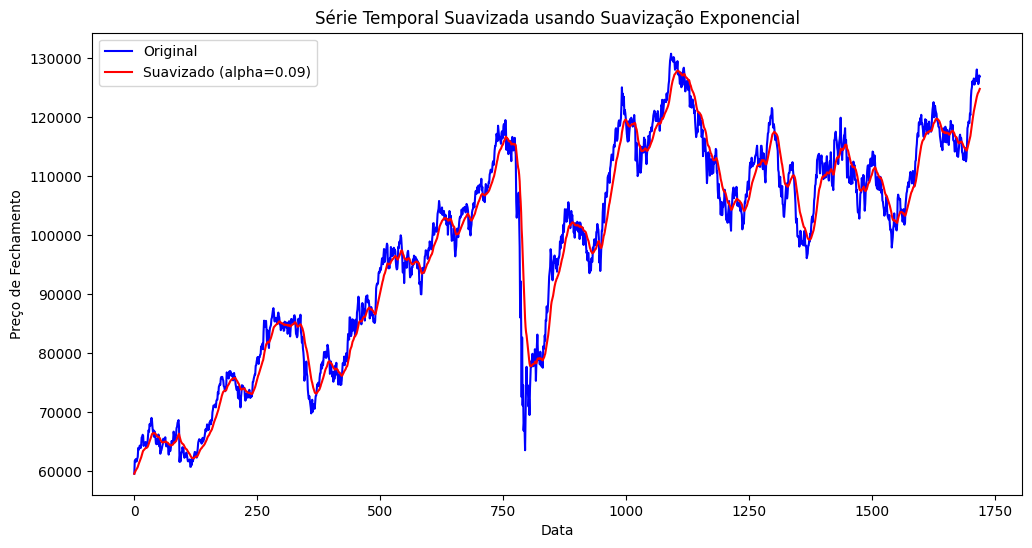

In [456]:
# Suazivando a série temporal
# Aplicando suavização exponencial
alpha = 0.09   # Fator de suavização
# O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.
# Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

df_lstm['Smoothed_Close'] = df_lstm['Close'].ewm(alpha=alpha, adjust=False).mean()

# Visualizando os resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df_lstm['Close'], label='Original', color='blue')
plt.plot(df.index, df_lstm['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='red')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [457]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df_lstm['Smoothed_Close'] )
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.0940174230450266
p-value: 0.24692702068543843
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.0940174230450266
Valor-p: 0.24692702068543843
Valores Críticos:
   1%: -3.434175427574795
   5%: -2.8632297119111967
   10%: -2.567669556525133


In [458]:
df_lstm

,Date,Close,Smoothed_Close
0,2017-01-02,59589.0,59589.000000
1,2017-01-03,61814.0,59789.250000
2,2017-01-04,61589.0,59951.227500
3,2017-01-05,62071.0,60142.007025
4,2017-01-06,61665.0,60279.076393
...,...,...,...
1716,2023-12-05,126903.0,124052.803004
1717,2023-12-06,125623.0,124194.120734
1718,2023-12-07,126010.0,124357.549868
1719,2023-12-08,127094.0,124603.830380


In [459]:
df_lstm.drop(columns=['Close'], inplace=True)

df_lstm.head()

,Date,Smoothed_Close
0,2017-01-02,59589.000000
1,2017-01-03,59789.250000
2,2017-01-04,59951.227500
3,2017-01-05,60142.007025
4,2017-01-06,60279.076393


In [460]:
close_data = df_lstm['Smoothed_Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [461]:
close_data

array([[0.        ],
       [0.0029304 ],
       [0.00530073],
       ...,
       [0.94780418],
       [0.95140818],
       [0.95445339]])

In [462]:
plit_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df_lstm['Date'][:split]
date_test = df_lstm['Date'][split:]

print(len(close_train))
print(len(close_test))

1376
345


In [463]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 5

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [464]:
np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])

num_epochs = 100
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100
69/69 [==============================] - 2s 8ms/step - loss: 0.0665 - mean_squared_error: 0.0665
Epoch 2/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 3/100
69/69 [==============================] - 1s 8ms/step - loss: 6.2166e-04 - mean_squared_error: 6.2166e-04
Epoch 4/100
69/69 [==============================] - 1s 8ms/step - loss: 5.4515e-04 - mean_squared_error: 5.4515e-04
Epoch 5/100
69/69 [==============================] - 1s 8ms/step - loss: 3.5105e-04 - mean_squared_error: 3.5105e-04
Epoch 6/100
69/69 [==============================] - 0s 6ms/step - loss: 3.3220e-04 - mean_squared_error: 3.3220e-04
Epoch 7/100
69/69 [==============================] - 0s 6ms/step - loss: 2.5225e-04 - mean_squared_error: 2.5225e-04
Epoch 8/100
69/69 [==============================] - 0s 6ms/step - loss: 3.4302e-04 - mean_squared_error: 3.4302e-04
Epoch 9/100
69/69 [==============================] - 0s 6ms/step - loss: 2.8300e

In [465]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f"MAPE: {mape:.2f}%")

340/340 [==============================] - 2s 5ms/step
MAPE: 0.84%


In [466]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio:", mse[0])

340/340 [==============================] - 1s 3ms/step - loss: 9.2469e-05 - mean_squared_error: 9.2469e-05
Erro Quadrático Médio: 9.246930130757391e-05


In [467]:
# O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.009616095949374357


In [468]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições do IBOVESPA",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

340/340 [==============================] - 1s 3ms/step


Agora chegou o momento de prever o futuro!  Realizando o Forecasting!!

Vamos criar uma função para prever o futuro, vamos passar como parametro um número X de dias e a ideia dessa função é excutar o predict do modelo para nos retornar os dias futuros.

In [469]:
close_data = close_data.reshape((-1))


# Função para prever os próximos 'num_prediction' pontos da série temporal
# Utiliza o modelo treinado para prever cada ponto sequencialmente
# A cada iteração, adiciona a previsão à lista 'prediction_list'

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'Date' contendo as datas

def predict_dates(num_prediction):
    last_date = df_lstm['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 15 #definição dos próximos dias
forecast = predict(num_prediction, model) #resultado de novos dias
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 23ms/step


In [470]:
trace1 = go.Scatter(
    x = date_test,
    y = close_test,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast IBOVESPA",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [471]:
#Organizando os dados em um dataframe

In [472]:
df = pd.DataFrame(df_lstm)
df_past = df[['Date','Smoothed_Close']]
df_past.rename(columns={'Smoothed_Close': 'Actual'}, inplace=True)         #criando nome das colunas
df_past['Date'] = pd.to_datetime(df_past['Date'])                          #configurando para datatime
df_past['Forecast'] = np.nan                                               #Preenchendo com NAs
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_past.head(3)

,Date,Actual,Forecast
0,2017-01-02,59589.0000,NaN
1,2017-01-03,59789.2500,NaN
2,2017-01-04,59951.2275,NaN


In [473]:
# Faz a transformação inversa das predições
forecast = forecast.reshape(-1, 1) #reshape para array
forecast = scaler.inverse_transform(forecast)

In [474]:
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['Actual'] = np.nan
df_future.head()

,Date,Actual,Forecast
0,2023-12-11,NaN,124811.925645
1,2023-12-12,NaN,125506.118777
2,2023-12-13,NaN,125952.685915
3,2023-12-14,NaN,126472.361224
4,2023-12-15,NaN,126956.665684


In [475]:
# Concatenando os DataFrames usando concat
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('Date')
results.head()

,Actual,Forecast
Date,,
2017-01-02,59589.000000,NaN
2017-01-03,59789.250000,NaN
2017-01-04,59951.227500,NaN
2017-01-05,60142.007025,NaN
2017-01-06,60279.076393,NaN


In [476]:
results.tail()

,Actual,Forecast
Date,,
2023-12-22,NaN,130658.670521
2023-12-23,NaN,131217.948634
2023-12-24,NaN,131786.374942
2023-12-25,NaN,132364.389340
2023-12-26,NaN,132951.649688


In [477]:
results2023 =  results.loc['2023-01-01':] #mudar de acordo com a janela utilizada no começo e olhando os resultados acima

In [478]:
plot_data = [
    go.Scatter(
        x=results2023.index,
        y=results2023['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results2023.index,
        y=results2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast IBOVESPA'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

import plotly as ply
ply.offline.plot(fig)

'temp-plot.html'